# Participantes-
- Danny Valerio Ramírez
- Josué Valerio Ramírez
- Francini Corrales Garro

In [1]:
from qiskit import QuantumCircuit, transpile, assemble#,execute
from qiskit_aer import AerSimulator  # Importa AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import Estimator, Options

import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
 
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

## Crear el ciruito

# Creación de un circuito con resultados equiprobable 
En condiciones ideales (como en un simulador que no se ve directamente afectado directamente por ruido ) se requiere la construcción de un circuito con compuertas Hadamard  y una medción en cada uno de los qubits.  Las compuertas Hadamard permiten poner a los qubits en un estado de superposición equiprobable lo que nos permite la creación de un número aleatorio al realizar la medición.

Sin embargo, en el mundo real las computadoras cuánticas se ven directamente afectadas por el ruido cuántico.

A continuación mostrarmos un circuito capaz de generar números aleatorios de n dígitos. 

Para este ejemplo trabajaremos con un numero de qubits igual a 4 lo que nos permitirá generar números aleatorios entre 0 y 15 (lo que es equivalente a 0000 - 1111 en notación binaria).

In [2]:
n = 4  # Número de qubits para definir el rango de números aleatorios

qc = QuantumCircuit(n) # Creamos el circuito
qc.h(range(n))  # Creamos una superposición equiprobable

qc.measure_all()  # Realizamos la medición

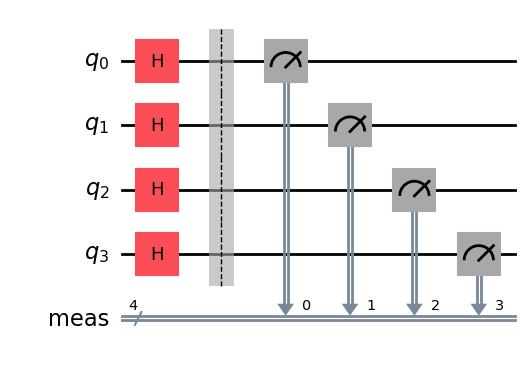

In [3]:
qc.draw('mpl')

# Creación de un simulador FakeSherBrooke
El módulo de fake provider contiene clases de proveedores falsos y backends falsos. Los fake backends están diseñados para imitar el comportamiento de los sistemas de IBM Quantum utilizando instantáneas del sistema. Las instantáneas del sistema contienen información importante sobre el sistema cuántico, como el mapa de acoplamiento, las puertas base, las propiedades de los qubits (T1, T2, tasa de error, etc.), lo que es útil para probar el transpiler y realizar simulaciones ruidosas del sistema. Para más información, visita: https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/fake_provider

Para simular el comportamiento con ruido decidimos utilizar el FakeBackendV2 initializer.

# Experimento 1 
Inicialmente decidimos correr el circuito un número de  30 veces. 
Como se puede observar en la gráfica adjunta. El resultado parece tener un sesgo importante ya que los números parecen salir mucho más que otros.Diríamos entonces que realmente no son equiprobables en est escenario. 

In [4]:
backend = FakeSherbrooke()
transpiled_qc = transpile(qc, backend)  # Transpilar el circuito para el simulador
results = backend.run(transpiled_qc, shots=30).result()  # Ejecuta el circuito en el simulador
counts = results.get_counts()

## Resultado de experimento 1

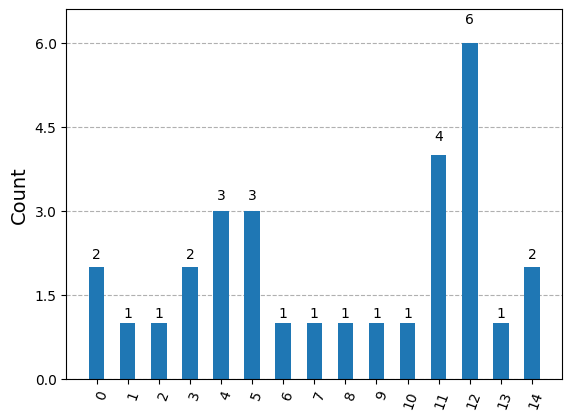

In [5]:
int_counts = {}
for bitstring in counts:
    int_counts[ int(bitstring,2) ] = counts[bitstring]
plot_histogram(int_counts)

In [6]:
max_result = max(counts, key=counts.get)  # Encuentra la clave con el valor máximo
max_frequency = counts[max_result]  # Obtiene la frecuencia de esa clave

print("El resultado más frecuente es:",  int(max_result,2) )
print("Frecuencia del resultado más frecuente:", max_frequency)

El resultado más frecuente es: 12
Frecuencia del resultado más frecuente: 6


# Experimento 2
Seguidamente decidimos correr el circuito un número de  10000000 veces. 
Como se puede observar en la gráfica adjunta. El resultado parece tener un sesgo menor cuando se aumenta el número de iteraciones. Sin embargo, no podemos asegurar que no siga existiendo un sesgo debido a la probabilidad de que esté ocurriendo un error cuántico.

In [7]:
results = backend.run(transpiled_qc, shots=10000000).result()  # Ejecuta el circuito en el simulador
counts = results.get_counts()

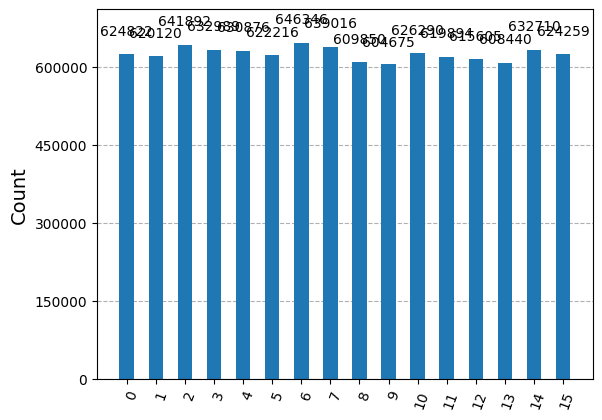

In [8]:
int_counts = {}
for bitstring in counts:
    int_counts[ int(bitstring,2) ] = counts[bitstring]
plot_histogram(int_counts)

In [9]:
max_result = max(counts, key=counts.get)  # Encuentra la clave con el valor máximo
max_frequency = counts[max_result]  # Obtiene la frecuencia de esa clave

print("El resultado más frecuente es:",  int(max_result,2) )
print("Frecuencia del resultado más frecuente:", max_frequency)

El resultado más frecuente es: 6
Frecuencia del resultado más frecuente: 646346


## Optimizar el ruido

A continuación presentaremos un posible escenario ideal sin ruido

In [10]:
# Example error probabilities
p_reset = 0.0
p_meas = 0.0
p_gate1 = 0.0
 
# QuantumError objects
error_reset = pauli_error([("X", p_reset), ("I", 1 - p_reset)])
error_meas = pauli_error([("X", p_meas), ("I", 1 - p_meas)])
error_gate1 = pauli_error([("X", p_gate1), ("I", 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
 
# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["h"])
#noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])
 
print(noise_bit_flip)

NoiseModel: Ideal


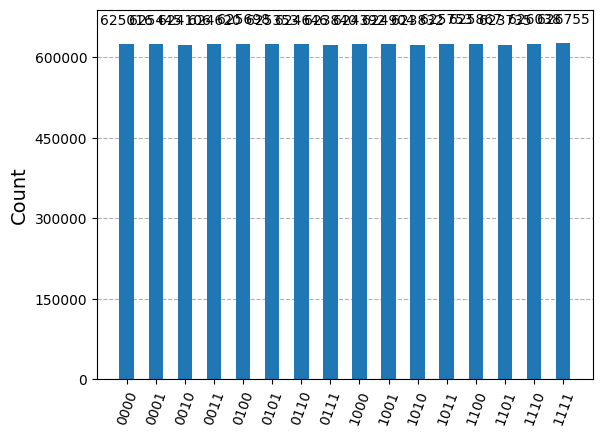

In [11]:
# Create noisy simulator backend
#sim_noise = AerSimulator(noise_model=noise_bit_flip)
sim_noise=FakeSherbrooke()
 
# Transpile circuit for noisy basis gates
passmanager = generate_preset_pass_manager(
    optimization_level=3, backend=sim_noise
)
circ_tnoise = passmanager.run(qc)
 
# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise, shots=10000000,noise_model=noise_bit_flip).result()
counts_bit_flip = result_bit_flip.get_counts(0)
 
# Plot noisy output
plot_histogram(counts_bit_flip)

# Escenario con ruido 
En este caso se trato de configurar un escenario ideal  donde las iteraciones tienden hacer mucho más equiprobables que en los escenarios 1  y 2. Para esto se bajo el error de medición 0 (NoiseModel: Ideal). En un escenario real con una computadora cúantica será necesario la aplicación de métodos de mitigación de ruido que permitan acercar estos valores a los valores esperados.

Una de las técnicas que permite esto es el  Zero-noise extrapolation (ZNE) o Probabilistic Error Amplification. https://docs.quantum.ibm.com/guides/error-mitigation-and-suppression-techniques#zero-noise-extrapolation-zne 